Prevent SSL error

In [1]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

Importing packages

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, precision_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import nltk as nl
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
nl.download('punkt')
nl.download('stopwords')
nl.download('rslp')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marciosilveira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marciosilveira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     /Users/marciosilveira/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

# Predict the vote by party

Create dataframe based on csv

In [3]:
impeachment = pd.read_csv('impeachment_br.csv',index_col=0)

Some feature engineering

In [4]:
def trata_voto(x):
    if x == 'Sim':
        return 1
    else:
        return 0

impeachment['Voto'] = impeachment['Voto'].apply(trata_voto)

Splitting train and test

In [5]:
X = pd.get_dummies(impeachment[['Partido']])
y = impeachment['Voto']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Choosing best n based on accuracy score

Chosen n is: 5.0


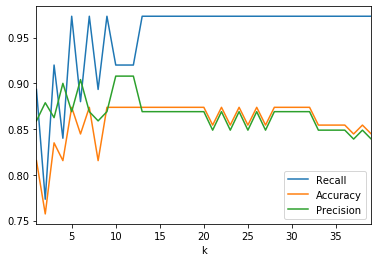

In [6]:
metrics = pd.DataFrame(columns=['k', 'Accuracy', 'Recall', 'Precision'])
for k in range(1, 40):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    metrics.loc[k] = [k, accuracy, recall, precision]

metrics.sort_values(by=['Recall', 'Precision', 'Accuracy'], ascending=False)
ax = metrics.plot(kind='line', x='k', y='Recall')
metrics.plot(kind='line', x='k', y='Accuracy', ax=ax)
metrics.plot(kind='line', x='k', y='Precision', ax=ax)

max_accuracy = metrics['Accuracy'].max()
ns = list(metrics[metrics['Accuracy'] == max_accuracy]['k'])
n = ns[0]
print('Chosen n is:', n)

In [7]:
model = KNeighborsClassifier(n_neighbors=int(n))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Metrics

In [8]:
print('Accuracy score:', accuracy_score(y_test, y_pred), '\n\n')
print('Confusion matrix:\n\n', confusion_matrix(y_test, y_pred), '\n\n')
print('Classification report:\n\n', classification_report(y_test, y_pred))

Accuracy score: 0.8737864077669902 


Confusion matrix:

 [[17 11]
 [ 2 73]] 


Classification report:

               precision    recall  f1-score   support

           0       0.89      0.61      0.72        28
           1       0.87      0.97      0.92        75

    accuracy                           0.87       103
   macro avg       0.88      0.79      0.82       103
weighted avg       0.88      0.87      0.87       103



# Predict the vote by speech

In [9]:
impeachment = pd.read_csv('impeachment_br.csv',index_col=0)

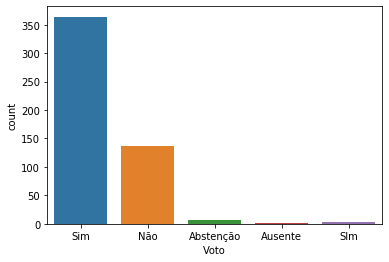

In [10]:
sns.countplot(impeachment['Voto'])

The proportions of yes and no would imply in bias, let's sample by the size of the no, then...

In [11]:
yes = impeachment.loc[impeachment['Voto'] == 'Sim']
no = impeachment.loc[impeachment['Voto'] == 'Não']
sample_yes = yes.sample(len(no))

Now let's create a sample dataframe with the same proportions of yes and no to avoid bias...

In [12]:
sample_votes = pd.concat([no, sample_yes], axis=0)

Now let's add a space between the speeches

In [13]:
def add_space(x):
    return ' ' + x


sample_votes['Fala'] = sample_votes['Fala'].apply(add_space)

Now let's separate the yes and no to create the corpus

In [14]:
yes = sample_votes.loc[sample_votes['Voto'] == 'Sim']
no = sample_votes.loc[sample_votes['Voto'] == 'Não']

text_yes = yes['Fala'].sum()
text_no = no['Fala'].sum()

In [15]:
token_yes = word_tokenize(text_yes)
token_no = word_tokenize(text_no)

Removing Portuguese stopwords and ignoring symbols and len(word) < 1

In [16]:
list_yes = []
for word in token_yes:
    if word not in stopwords.words('Portuguese') and len(word) > 1:
        list_yes.append(word)

list_no = []
for word in token_no:
    if word not in stopwords.words('Portuguese') and len(word) > 1:
        list_no.append(word)

series_yes = pd.Series(list_yes)
series_no = pd.Series(list_no)

Most said words

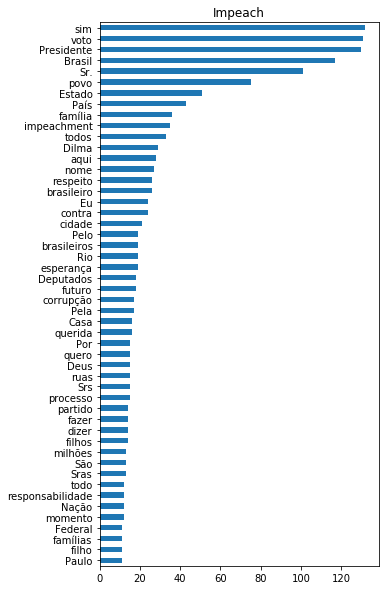

In [17]:
m_yes = series_yes.value_counts().head(50).sort_values()
m_yes.plot(kind='barh', figsize=(5, 10), title='Impeach')

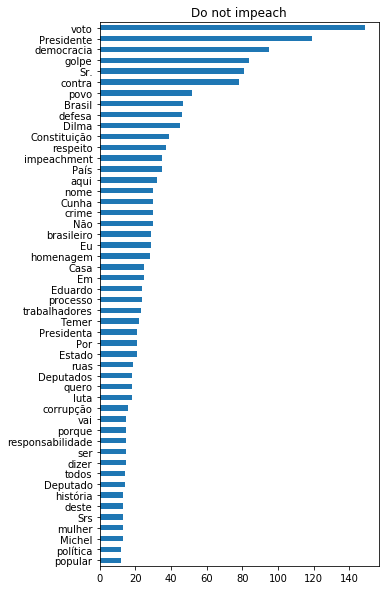

In [18]:
m_no = series_no.value_counts().head(50).sort_values()
m_no.plot(kind='barh', figsize=(5, 10), title='Do not impeach')

In [19]:
def labels(column):
    speech = column['Fala']
    vote = column['Voto']
    token = word_tokenize(speech)
    words = []
    if vote == 'Sim':
        for word in token:
            if word in m_yes.index:
                words.append(word)
    if vote == 'Não':
        for word in token:
            if word in m_no.index:
                words.append(word)
    return words

label = sample_votes.apply(labels, axis=1)

mlb = MultiLabelBinarizer()
data = mlb.fit_transform(label)
columns = mlb.classes_
label_2 = pd.DataFrame(data=data, columns=columns, index=sample_votes.index)
data_2 = pd.concat([sample_votes, label_2], axis=1)

In [20]:
X = data_2.drop(['Partido', 'Estado', 'Voto', 'Gênero', 'Fala'], axis=1)
y = data_2['Voto'].astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Model

In [21]:
model = MLPClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

/Users/marciosilveira/.virtualenvs/data_science/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [22]:
print('Accuracy score:', accuracy_score(y_test, y_pred), '\n\n')
print('Confusion matrix:\n\n', confusion_matrix(y_test, y_pred), '\n\n')
print('Classification report:\n\n', classification_report(y_test, y_pred))

Accuracy score: 1.0 


Confusion matrix:

 [[27  0]
 [ 0 28]] 


Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        28

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55



In [23]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(metric='manhattan')

model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)

In [24]:
print('Accuracy score:', accuracy_score(y_test, y_pred_knn), '\n\n')
print('Confusion matrix:\n\n', confusion_matrix(y_test, y_pred_knn), '\n\n')
print('Classification report:\n\n', classification_report(y_test, y_pred_knn))

Accuracy score: 0.8727272727272727 


Confusion matrix:

 [[27  0]
 [ 7 21]] 


Classification report:

               precision    recall  f1-score   support

           0       0.79      1.00      0.89        27
           1       1.00      0.75      0.86        28

    accuracy                           0.87        55
   macro avg       0.90      0.88      0.87        55
weighted avg       0.90      0.87      0.87        55

